# SINDy attempts

## How it works
Suppose we have a set of measurements $x(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy seeks to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

This equation constitutes a *dynamical system* for the measurements $x(t)$. The vector $x(t)=[x_1(t), x_2(t), \dots x_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(x(t))$ constrains how the system evolves in time.

The key idea behind SINDy is that the function $f$ is often **sparse** in the space of an appropriate set of basis functions. For example, the function

$$
	\frac{d}{dt}x = f(x)
	= \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
	= \begin{bmatrix}1 - x_1 + 3x_1x_2 \\ x_2^2 - 5x_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(x) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.

## Structure of PySINDy
Consider a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). These data are aggregated into the matrices $X$ and $\dot X$, respectively

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}.
$$

Next, one forms a library matrix $\Theta(X)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

For example, if $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ are monomials ($\theta_i(x) = x^{i-1}$), then

$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ representing the $i$th component function of $f$: $f_i(x)$. That is to say, $f_i(x) = \Theta\left(x^\top\right) \xi_i$, where $\Theta\left(x^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(X)$ is a matrix whose entries are numerical values).

With each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$


The submodules of PySINDy are each aligned with one of the terms in the aforementioned approximation equation

 * `pysindy.differentiate` performs numerical differentiation to compute $\dot X$ from $X$;
 * `pysindy.feature_library` allows the user to specify a set of library functions and handles the formation of $\Theta(X)$;
 * `pysindy.optimizers` provides a set of sparse regression solvers for determining $\Xi$.

The `SINDy` object encapsulates one class object from each of these three submodules and uses them, along with a user-supplied data matrix, to find a governing dynamical system.

## SIS Model Discovery
Here, we are trying to discover the governing equation for the SIS model and compare to the 2-step kernel method. Right now, the architecture is just for ODE, but there are SINDy methods for PDEs. We also want to discover the forcing function. Since this is only dependent on time, time will need to be included as a state variable (the derivative part will just be a column of ones along with the other states). For sinusoidal forcing, the coefficient will be able to discover the amplitude, but the frequency is embedded with the time argument. The only way around this (I think) is to include multiple sin / cos functions with different frequencies.

This notebook can be converted to a function:

* **Input = States $X$**: a matrix of the data, where columns are the states and rows are samples/observations in time. For SIS, this should look like the following:
$$
	X = \begin{bmatrix}
		I(t_1) & t_1\\
		I(t_2) & t_2\\
		\vdots & \vdots \\ I(t_m) & t_m
	\end{bmatrix}
$$

* **Process**

    * Compute derivatives of $X$ to form $\dot{X}$
	$$
		\dot{X} = \begin{bmatrix} \dot{I}(t_1) & 1 \\
			\dot{I}(t_2) & 1 \\
			\vdots & \vdots \\
			\dot{I}(t_m) & 1
		\end{bmatrix}.
	$$

	* Select feature library from package. Can select multiple and concatenate. Can also create a custom one.
	* Select sparse regression optimizer
    * Construct and fit model
* **Output**: ?? matrix of approximated solution in time using learned coeffs and corresponding basis functions - depends on what we decide we want to do for error and visualization



In [29]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from functools import partial
import sys
sys.path.append('../src')

The function would pass states data as input, but here we generate it for local testing

In [2]:
import KBio

In [63]:
beta = 4e-3 *100
gamma = 1e-3 *100
T_final = 3e1
dt = 1e-2  # for Euler step
data = KBio.rectangular_grid([0], [3e1], [30 + 1])
sim = KBio.SIS_sim(dt=dt, T_final=T_final, beta=beta, gamma=gamma, I0 = 5, S0 = 95)
sim(data, forcing = lambda x: 1.8e-2*np.sin(0.01 + 0.4*x))

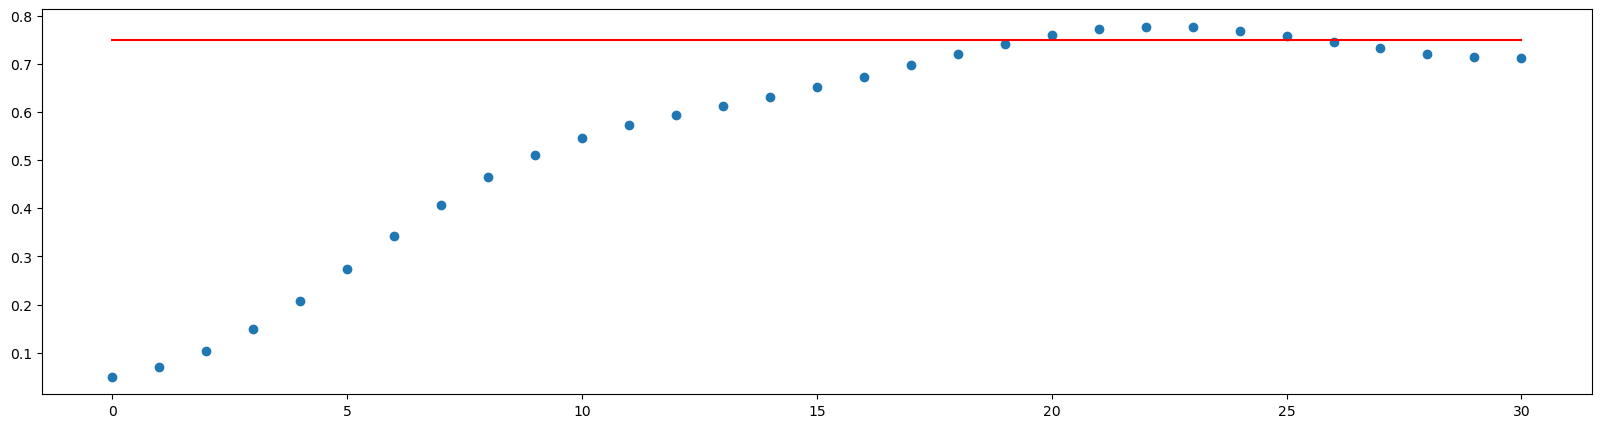

In [64]:
plt.figure(figsize=(20,5))
plt.plot(data.grid_tensors[0], data.grid_tensors_values, 'o')
# Put a vertical line at asymptotic steady state under no perturbation
steady_state = sim.asymptotic_steady_state() # 1 - 1/R0
# horizontal line from 0 to T_max at the asymptotic steady state
plt.plot([0, np.max(data.grid_tensors[0])], [steady_state, steady_state], 'r')

## Try with forcing

In [65]:
def oscillatory_forcing(A, omega, phi, t):
    return A*np.sin(omega + phi*t) * np.minimum(1, t/10)

def constant_forcing(A, t):
    return A * np.minimum(1, t/10)

In [76]:
n_samples_oscillatory = 10
# use log-uniform distribution to generate amplitudes
amplitudes = 10 ** (np.random.uniform(-1.8, -0.9, n_samples_oscillatory))

# use uniform distribution to generate frequencies
shifts = np.random.uniform(0, np.pi, n_samples_oscillatory)
print(shifts)
frequencies = np.random.uniform(1, 6, n_samples_oscillatory)
forcing_functions = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, frequency in zip(amplitudes, shifts, frequencies)]
grids_oscillatory = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_oscillatory)]
for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory, amplitudes, shifts, frequencies, forcing_functions):
    sim(grid, forcing = fn)

[0.0089864  0.96315749 1.63451018 0.35374873 0.84114842 1.09531615
 2.75362461 0.26526129 2.21162667 0.43699261]


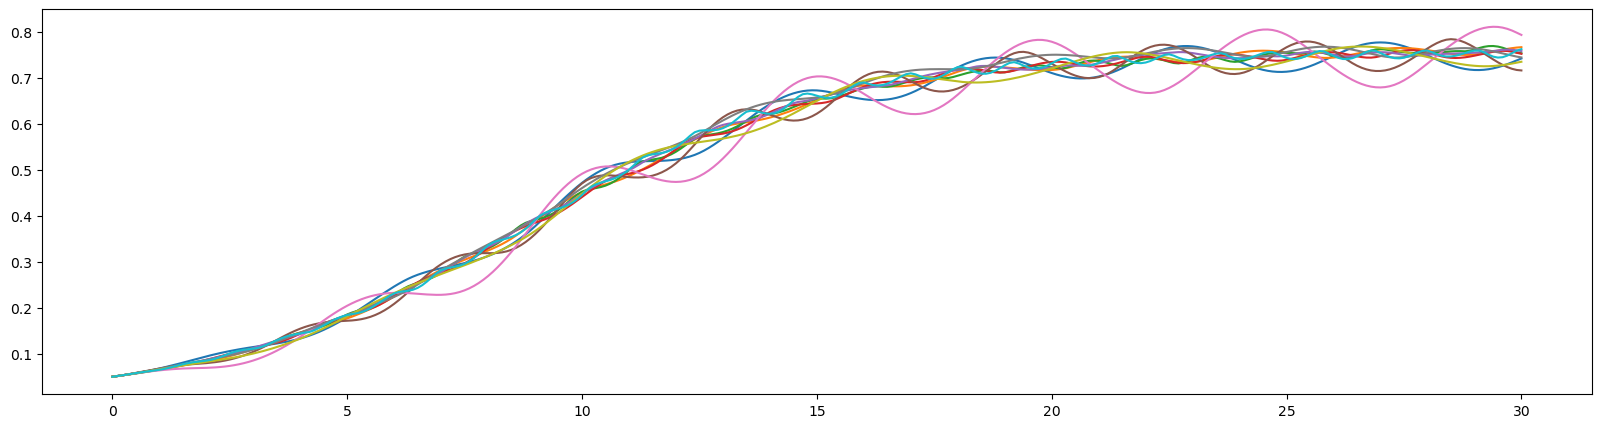

In [77]:
plt.figure(figsize=(20,5))
for grid in grids_oscillatory:
    plt.plot(grid.grid_tensors[0], grid.grid_tensors_values)

In [ ]:
# framework of function
for grid in grids_oscillatory:
    # assign I and t
    # assign SINDy submodule conditions
    # fit model
    # store model in a new list? need to pre-allocate space for these

In [33]:
t = data.grid_tensors[0]
I = data.grid_tensors_values
X = np.stack((I), axis=-1)
print(X)

[0.05       0.05017756 0.05042068 0.05071349 0.0510278  0.05130863
 0.05154611 0.05174117 0.05189623 0.05201526 0.05210371 0.05216861
 0.05221846 0.05226332 0.05231476 0.05238586 0.05249124 0.05264705
 0.05287093 0.05317379 0.05350436 0.0538232  0.05410463 0.05433097
 0.05449258 0.05458781 0.05462303 0.05461262 0.05457898 0.05455251
 0.05457109]


Define SINDy submodules

In [37]:
differentiation_method = ps.FiniteDifference(order=2)

feature_library_poly = ps.PolynomialLibrary(degree=3)
feature_library_sine = ps.FourierLibrary()
# feature_library = ps.ConcatLibrary([feature_library_poly, feature_library_sine])
feature_library = feature_library_poly

optimizer = ps.STLSQ(threshold=1e-6)

Construct and fit model

In [38]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["I", "t"], # I for infectious population, t for time
)

model.fit(X, t=t) # t should also be given in the def function input, but it's also a column in X for our purposes, so it could be extracted from there
model.print()

(I)' = -0.012 1 + 0.476 I + -4.814 I^2


could return the models from the function? Outside the func, will need to simulate the model with test data, plot, and compute error

Simulate new data with model and visualize

In [40]:
I0 = 0.1 # initial value for I
t0 = 0 # initial value for t
t_test = t # vector of time values over which to simulate dynamics
sim = model.simulate([I0], t=t_test)

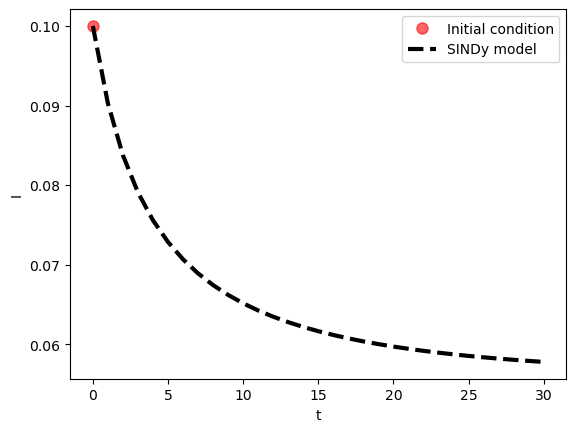

In [42]:
import matplotlib.pyplot as plt

plt.ion()

plt.figure()
plt.plot(t0, I0, "ro", label="Initial condition", alpha=0.6, markersize=8)
# plt.plot(t_test, I_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(t_test, sim[:, 0], "k--", label="SINDy model", linewidth=3)
plt.xlabel("t")
plt.ylabel("I")
plt.legend()
plt.show()

COOL! Now set up to work in a loop: cycle through all 

In [ ]:
def oscillatory_forcing(A, omega, phi, t):
    return A*np.sin(omega + phi*t) * np.minimum(1, t/10)

def constant_forcing(A, t):
    return A * np.minimum(1, t/10)

In [ ]:
n_samples_oscillatory = 10
# use log-uniform distribution to generate amplitudes
amplitudes = 10 ** (np.random.uniform(-3, -2.5, n_samples_oscillatory))

# use uniform distribution to generate frequencies
shifts = np.random.uniform(0, np.pi, n_samples_oscillatory)
print(shifts)
frequencies = np.random.uniform(1, 6, n_samples_oscillatory)
forcing_functions = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, frequency in zip(amplitudes, shifts, frequencies)]
grids_oscillatory = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_oscillatory)]
for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory, amplitudes, shifts, frequencies, forcing_functions):
    sim(grid, forcing = fn)